In [38]:
import os
import glob
import torch
import minari

import matplotlib.pyplot as plt
import statistics as stat
import numpy as np
import seaborn as sns

import torch.nn.functional as F
from torch import nn, Tensor
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence
from torchdyn.core import NeuralODE

from tqdm import tqdm
from natsort import natsorted

In [39]:
print(f"Torch version: {torch.__version__}")
print(f"Torch cuda version: {torch.version.cuda}")

Torch version: 2.6.0
Torch cuda version: 12.6


In [40]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

Device: cuda


In [41]:
def collate_fn(batch):
    observations = [torch.as_tensor(x.observations['observation']) for x in batch]
    lengths = torch.tensor([obs.shape[0] for obs in observations])  # Tensor of original lengths

    # Pad with zeros first
    padded_obs = torch.nn.utils.rnn.pad_sequence(observations, batch_first=True)

    # Use advanced indexing to replace padding with the last valid value
    mask = torch.arange(padded_obs.shape[1]).expand(len(batch), -1) >= lengths.unsqueeze(1)
    padded_obs[mask] = padded_obs[torch.arange(len(batch)), lengths - 1].unsqueeze(1).expand_as(padded_obs)[mask]

    return {
        "observations": padded_obs
    }

In [42]:
dataset = minari.load_dataset('D4RL/pointmaze/medium-v2')
print(f"Total amount of episodes: {dataset.total_episodes}") 
batch_size = 64

dataLoader = DataLoader(dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn, drop_last=True)
for batch in dataLoader:
    test_batch = batch['observations']
    print(f"test_batch.shape: {test_batch.shape}")
    break

Total amount of episodes: 4752
test_batch.shape: torch.Size([64, 474, 4])


## Dataset trajectory example
* One episode
* Based on the 'Observation' parameter of Observations.

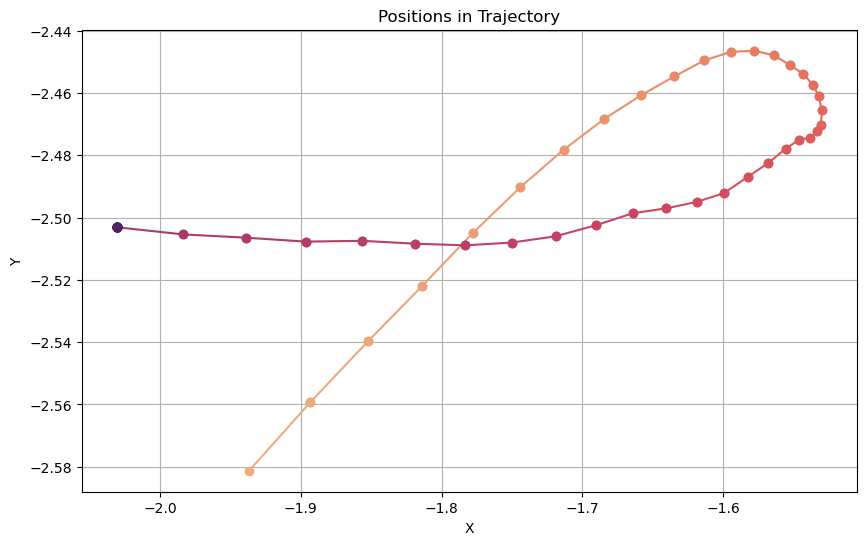

In [43]:
colors = sns.color_palette("flare", len(test_batch))

plt.figure(figsize=(10, 6))
for i in range(len(test_batch) - 1): # Traj plot
    plt.plot(test_batch[0, i:i+2, 0].cpu().numpy(), test_batch[0, i:i+2, 1].cpu().numpy(), color=colors[i], marker='o')
plt.title('Positions in Trajectory')
plt.xlabel('X')
plt.ylabel('Y')
plt.grid()

plt.show()

## FLOW MATCHING

In [44]:
import torch
import torch.nn as nn

class TrajectoryFlowModel(nn.Module):
    def __init__(self, obs_dim, hidden_dim=256, num_layers=5):
        """
        A neural network that estimates the velocity field for flow matching.

        Args:
            obs_dim (int): Dimensionality of observations (D_obs)
            hidden_dim (int): Number of hidden units in the MLP
            num_layers (int): Number of layers in the MLP
        """
        super().__init__()

        layers = []
        input_dim = obs_dim + 1  # We include time `t` as an input
        
        for i in range(num_layers - 1):
            layers.append(nn.Linear(input_dim, hidden_dim))
            
            # Alternating activation functions for better gradient flow and expressivity
            if i % 2 == 0:
                layers.append(nn.SiLU())  # Swish/SiLU for smoothness
            else:
                layers.append(nn.ReLU())  # ReLU for stability
            
            input_dim = hidden_dim 
        
        layers.append(nn.Linear(hidden_dim, obs_dim))  # Output layer, no activation
        self.network = nn.Sequential(*layers)

    def forward(self, x, t):
        """
        Forward pass for the trajectory flow model.
        """

        velocity = self.network(xt) 
        return velocity


In [45]:
observation_lst = []
max_batches = 20
for count, batch in enumerate(dataLoader):
    if count == max_batches:
        break
    obs = batch['observations']
    observation_lst.append(obs)

In [55]:
def compute_mu_t(x1, t):
    t_expanded = t[:, None, None].expand(-1, x1.shape[1], -1)
    return t_expanded * x1

In [48]:
def compute_sigma(self, t, sigma):
    sigma = 1 - (1 - sigma) * t
    return sigma

In [49]:
def compute_conditional_vector_field(x0, x1, t, xt, sigma):
    # return x1 - x0
    t_expanded = t[:, None, None].expand(-1, xt.shape[1], -1)
    return (x1 - (1 - sigma) * xt) / (1 - (1 - sigma) * t_expanded) # Eq. 20, Lipman 2023

In [50]:
def sample_xt(x0, x1, t):
    epsilon = torch.randn_like(x0).to(device=x0.device, dtype=torch.float32)
    mu_t = compute_mu_t(x1, t)
    return mu_t + sigma * epsilon 

In [51]:
def sample_and_compute(x0, x1, t, sigma):
    
    xt = sample_xt(x0, x1, t)
    ut = compute_conditional_vector_field(x0, x1, t, xt, sigma)

    return t, xt, ut

In [52]:
class torch_wrapper(nn.Module):
    """Wraps model to torchdyn compatible format."""

    def __init__(self, model):
        super().__init__()
        self.model = model

    def forward(self, t, x, *args, **kwargs):
        t = t.repeat(x.shape[0])[:, None, None] # Repeats t along first dim, [batch_size, 1, 1]
        return self.model(x, t)

In [53]:
def single_gaussian_sample_alt(batch_size, sec_dim, traj_dim, sigma, device=device, var=1.0):
    """
    Generate samples from a single Gaussian distribution centered at the origin.

    Args:
        batch_size (int): Number of batches.
        sec_dim (int): Number of sections (sequence length).
        traj_dim (int): Dimensionality of each trajectory point.
        var (float): Variance of the Gaussian distribution.

    Returns:
        torch.Tensor: Tensor of shape (n, dim) containing sampled points.
    """

    
    single_sample = torch.randn(batch_size, sec_dim, traj_dim) * var**0.5
    return single_sample.to(device, dtype=torch.float32)

## Training

In [77]:
num_epochs = 10
lr = 3e-3
  
save_path = "fm_model_checkpoint.pth"
xt_prog = []
losses = []

sigma = 0.1
traj_dim = 4 # [xpos, ypos, xvel, yvel]
flow_model = TrajectoryFlowModel(traj_dim).to(device)
optimizer = torch.optim.AdamW(flow_model.parameters(), lr=lr)


for epoch in range(num_epochs):
    for batch in tqdm(dataLoader, desc=f"Training Progress"):
        observations = batch['observations'].to(device)
        x1 = observations
        x0 = torch.rand_like(x1).to(device)
        t = torch.rand((x1.shape[0],), device=device)

        t, xt, ut = sample_and_compute(x0, x1, t, sigma=sigma)
        # xt = sample_conditional_pt(x0, x1, t, sigma=sigma).to(device, dtype=torch.float32)
        # ut = compute_conditional_vector_field(x0, x1, t, xt, sigma=sigma).to(device, dtype=torch.float32)

        t_expanded = t[:, None, None].expand(-1, xt.shape[1], -1)
        xt = torch.cat([xt, t_expanded], dim=-1).to(device, dtype=torch.float32) # Mulig feilen ligger her.
        
        vt = flow_model(xt, t)

        xt_prog.append(xt)

        loss = torch.mean((vt - ut) ** 2)
        loss = loss.to(device, dtype=torch.float32)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        losses.append(loss.item())

    # Save checkpoint after each epoch
    checkpoint = {
        'model_state_dict': flow_model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'losses': losses,
        'learning_rate': lr,
        'sigma': sigma,
        'vt': vt
    }

    torch.save(checkpoint, save_path)
    print(f"Checkpoint saved to {save_path} after epoch {epoch + 1}")

Training Progress: 100%|██████████| 74/74 [01:14<00:00,  1.00s/it]


Checkpoint saved to fm_model_checkpoint.pth after epoch 1


Training Progress: 100%|██████████| 74/74 [01:20<00:00,  1.09s/it]


Checkpoint saved to fm_model_checkpoint.pth after epoch 2


Training Progress: 100%|██████████| 74/74 [01:17<00:00,  1.04s/it]


Checkpoint saved to fm_model_checkpoint.pth after epoch 3


Training Progress: 100%|██████████| 74/74 [01:16<00:00,  1.04s/it]


Checkpoint saved to fm_model_checkpoint.pth after epoch 4


Training Progress: 100%|██████████| 74/74 [01:15<00:00,  1.02s/it]


Checkpoint saved to fm_model_checkpoint.pth after epoch 5


Training Progress: 100%|██████████| 74/74 [01:15<00:00,  1.02s/it]


Checkpoint saved to fm_model_checkpoint.pth after epoch 6


Training Progress: 100%|██████████| 74/74 [01:27<00:00,  1.18s/it]


Checkpoint saved to fm_model_checkpoint.pth after epoch 7


Training Progress: 100%|██████████| 74/74 [01:36<00:00,  1.30s/it]


Checkpoint saved to fm_model_checkpoint.pth after epoch 8


Training Progress: 100%|██████████| 74/74 [01:31<00:00,  1.24s/it]


Checkpoint saved to fm_model_checkpoint.pth after epoch 9


Training Progress: 100%|██████████| 74/74 [01:30<00:00,  1.22s/it]

Checkpoint saved to fm_model_checkpoint.pth after epoch 10


In [78]:
save_path = "fm_model_checkpoint.pth"
checkpoint = torch.load(save_path, map_location=device)

flow_model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
losses = checkpoint.get('losses', [])
lr = checkpoint['learning_rate']
sigma = checkpoint['sigma']
vt = checkpoint['vt']

print("Checkpoint loaded successfully!")

Checkpoint loaded successfully!


In [79]:
def plot_trajectories(traj, batch_size, observation_lst):
    """Plot trajectories of some selected samples."""
    print(f"Plot trajs: traj shape {traj.shape}")
    n = batch_size  # Batch_size
    plt.figure(figsize=(6, 6))
    plt.scatter(traj[0, :n, 0], traj[0, :n, 1], s=10, alpha=0.8, c="black", label="Noisy Sample")
    plt.scatter(traj[:, :n, 0], traj[:, :n, 1], s=0.2, alpha=0.2, c="red", label="Flow")
    plt.scatter(traj[-1, :n, 0], traj[-1, :n, 1], s=4, alpha=1, c="blue", label="Target Sample")
    # for observations in observation_lst:
    #     plt.plot(observations[0, :, 0].cpu().numpy(), observations[0, :, 1].cpu().numpy(), color='g', alpha=0.5)  
    plt.legend()
    plt.title("Flow Matching Evolution")
    plt.grid(True)
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.show()

In [80]:
def sample_and_plot(flow_model, batch_size, xt, traj_dim, sigma, observation_lst, solver="dopri5"):
    node = NeuralODE(
        torch_wrapper(flow_model), solver=solver, sensitivity="adjoint", atol=1e-4, rtol=1e-4
    )
    with torch.no_grad():
        traj = node.trajectory(
            single_gaussian_sample_alt(batch_size, xt.shape[1], traj_dim, sigma),
            t_span = torch.linspace(0, 1, 100, device=device, dtype=torch.float32),
        )
        plot_trajectories(traj.cpu().numpy(), batch_size, observation_lst)

Plot trajs: traj shape (100, 64, 471, 4)


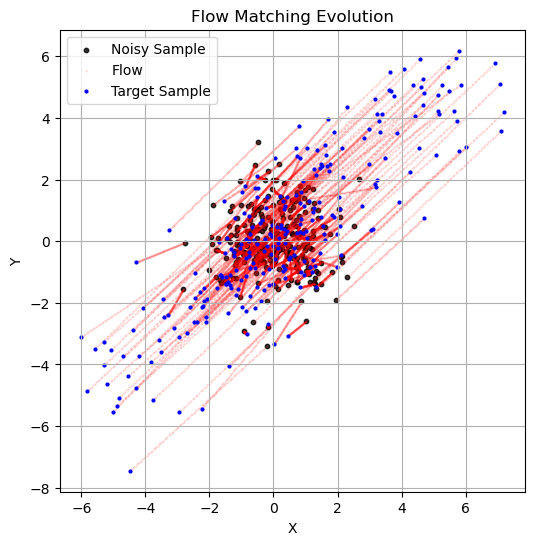

Shape of x1 torch.Size([64, 493, 4])
tensor([[[-1.1006e+00,  6.6575e-01,  2.4595e+00,  2.2817e+00],
         [-1.0737e+00,  6.8614e-01,  2.6918e+00,  2.0381e+00],
         [-1.0493e+00,  7.0409e-01,  2.4472e+00,  1.7951e+00],
         ...,
         [-3.9621e-01, -1.8607e+00,  1.0608e-01,  4.8280e+00],
         [-3.9621e-01, -1.8607e+00,  1.0608e-01,  4.8280e+00],
         [-3.9621e-01, -1.8607e+00,  1.0608e-01,  4.8280e+00]],

        [[-1.0144e+00,  3.8922e-01, -4.9274e+00, -9.2205e-01],
         [-1.0639e+00,  3.8241e-01, -4.9465e+00, -6.8169e-01],
         [-1.1135e+00,  3.7323e-01, -4.9642e+00, -9.1823e-01],
         ...,
         [ 2.2393e+00,  2.4978e+00,  4.9289e+00, -2.9904e-03],
         [ 2.2393e+00,  2.4978e+00,  4.9289e+00, -2.9904e-03],
         [ 2.2393e+00,  2.4978e+00,  4.9289e+00, -2.9904e-03]],

        [[-2.5196e+00, -9.4364e-01, -3.0802e-01, -4.4866e+00],
         [-2.5208e+00, -9.9078e-01, -1.1481e-01, -4.7141e+00],
         [-2.5208e+00, -1.0377e+00, -6.2738e-03, 

In [88]:
xt = xt_prog[4]
sample_and_plot(flow_model, batch_size, xt, traj_dim, sigma, observation_lst)
print(f"Shape of x1 {x1.shape}\n{x1}")

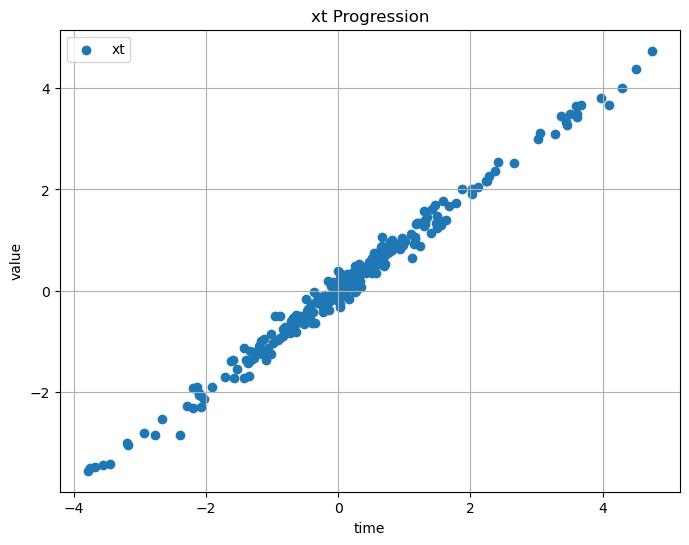

In [82]:
xt_lst = []
for ver in xt_prog:
    ver = ver.cpu().numpy()
    xt_lst.append(ver)
plt.figure(figsize=(8, 6))
plt.scatter(xt_lst[0][:, 0], xt_lst[0][:, 1], label='xt', marker='o')
plt.title('xt Progression')
plt.xlabel('time')
plt.ylabel('value')
plt.legend()
plt.grid(True)
plt.show()

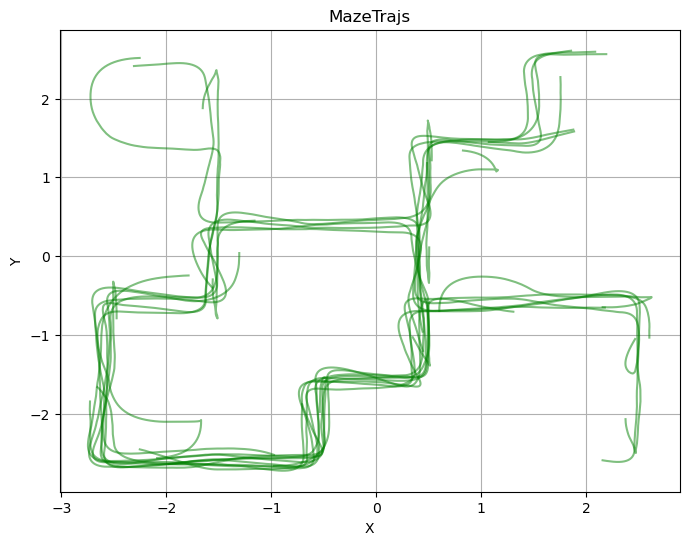

In [83]:
plt.figure(figsize=(8, 6))
for observations in observation_lst:
    plt.plot(observations[0, :, 0].cpu().numpy(), observations[0, :, 1].cpu().numpy(), color='g', alpha=0.5)
plt.title('MazeTrajs')
plt.xlabel('X')
plt.ylabel('Y')
plt.grid()
plt.show()

# Load model

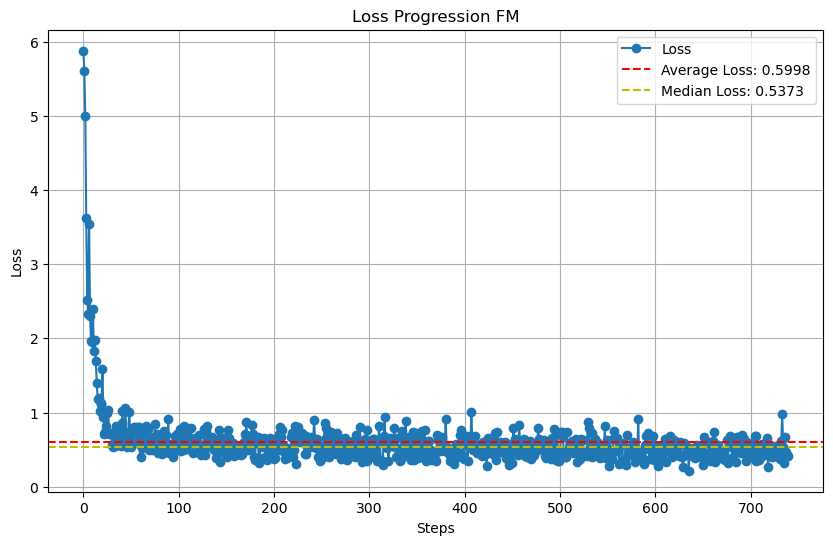

In [84]:
avg_loss = sum(losses)/len(losses)
med_loss = stat.median(losses)

# losses[2] = med_loss
# print(losses)

save_dir = 'Plotted loss'
os.makedirs(save_dir, exist_ok=True)
plot_path = os.path.join(save_dir, 'loss_plot.png')

plt.figure(figsize=(10, 6))
plt.plot(losses, label='Loss', marker='o')
plt.axhline(y=avg_loss, color='r', linestyle='--', label=f'Average Loss: {avg_loss:.4f}')
plt.axhline(y=med_loss, color='y', linestyle='--', label=f'Median Loss: {med_loss:.4f}')
plt.title('Loss Progression FM')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.savefig(plot_path)
plt.show()